In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
train_path = "../data/UNSW_NB15_training-set.csv"
test_path = "../data/UNSW_NB15_testing-set.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape: ", train_df.shape)
print("Test shape :", test_df.shape)

Train shape:  (175341, 45)
Test shape : (82332, 45)


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [4]:
train_df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
# Checking the distribution of classes

train_df['label'].value_counts()

label
1    119341
0     56000
Name: count, dtype: int64

In [6]:
# Dropping non-feature columns

DROP_COLS = ['id', 'attack_cat', 'label']

X_train = train_df.drop(columns=DROP_COLS, errors='ignore')
X_test = test_df.drop(columns=DROP_COLS, errors="ignore")

y_train = train_df['label']
y_test = test_df['label']

print(X_train.shape, X_test.shape)

(175341, 42) (82332, 42)


In [7]:
# one hot encoding
categorical_cols = ['proto', 'service', 'state']

combined = pd.concat([X_train, X_test], axis=0)

combined_encoded = pd.get_dummies(
    combined,
    columns=categorical_cols,
    drop_first=True
)

X_train = combined_encoded.iloc[:len(X_train)].copy()
X_test = combined_encoded.iloc[len(X_train):].copy()

print("After encoding:")
print(X_train.shape, X_test.shape)

After encoding:
(175341, 193) (82332, 193)


In [8]:
# Handling missing/ infinite values

def clean_numeric(df):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.median(), inplace=True)
    return df

X_train = clean_numeric(X_train)
X_test = clean_numeric(X_test)
    

In [10]:
# Cross Validation to tune n_estimators and contamination (Isolation Forest)

X = X_train.values
y = y_train.values

param_grid = {
    "n_estimators": [200, 400, 800],
    "contamination": [0.01, 0.02, 0.05, 0.08, 0.10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

results = []

for n_est in param_grid["n_estimators"]:
    for cont in param_grid["contamination"]:
        fold_aucs = []

        for train_idx, val_idx in cv.split(X,y):
            X_tr, y_tr = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            # Training only on Normal traffic
            X_tr_norm = X_tr[y_tr == 0]

            # Scale based on normal only training data
            scaler = StandardScaler()
            X_tr_norm_s = scaler.fit_transform(X_tr_norm)
            X_val_s = scaler.transform(X_val)

            # model

            iso =IsolationForest(
                n_estimators = n_est,
                contamination = cont,
                random_state = 24,
                n_jobs = -1
            )

            iso.fit(X_tr_norm_s)

            # anomaly score: higher = more anomalous
            scores = -iso.decision_function(X_val_s)

            # ROC-AUC against ground truth labels
            auc = roc_auc_score(y_val, scores)
            fold_aucs.append(auc)

            results.append({
                "n_estimators":n_est,
                "contamination":cont,
                "mean_auc": float(np.mean(fold_aucs)),
                "std_auc": float(np.std(fold_aucs))
            })

# SOrt best first

results_sorted = sorted(results, key=lambda d: d["mean_auc"], reverse=True)
results_sorted[:10]

[{'n_estimators': 200,
  'contamination': 0.01,
  'mean_auc': 0.8337523202600723,
  'std_auc': 0.004065826496493674},
 {'n_estimators': 200,
  'contamination': 0.02,
  'mean_auc': 0.8337523202600723,
  'std_auc': 0.004065826496493674},
 {'n_estimators': 200,
  'contamination': 0.05,
  'mean_auc': 0.8337523202600723,
  'std_auc': 0.004065826496493674},
 {'n_estimators': 200,
  'contamination': 0.08,
  'mean_auc': 0.8337523202600723,
  'std_auc': 0.004065826496493674},
 {'n_estimators': 200,
  'contamination': 0.1,
  'mean_auc': 0.8337523202600723,
  'std_auc': 0.004065826496493674},
 {'n_estimators': 200,
  'contamination': 0.01,
  'mean_auc': 0.8337373760185857,
  'std_auc': 0.0033198007059310904},
 {'n_estimators': 200,
  'contamination': 0.02,
  'mean_auc': 0.8337373760185857,
  'std_auc': 0.0033198007059310904},
 {'n_estimators': 200,
  'contamination': 0.05,
  'mean_auc': 0.8337373760185857,
  'std_auc': 0.0033198007059310904},
 {'n_estimators': 200,
  'contamination': 0.08,
  'mea

In [11]:
best = results_sorted[0]
best

{'n_estimators': 200,
 'contamination': 0.01,
 'mean_auc': 0.8337523202600723,
 'std_auc': 0.004065826496493674}

In [12]:
# Training only on normal traffic

X_train_normal = X_train[y_train==0]

print("Normal-only training data shape:", X_train_normal.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

Normal-only training data shape: (56000, 193)


### Isolation forest

In [13]:
best_n = best["n_estimators"]
best_c = best["contamination"]

iso = IsolationForest(
    n_estimators = best_n,
    contamination= best_c,
    random_state=24,
    n_jobs=-1    
)

iso.fit(X_train_scaled)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.01
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",24
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [14]:
# predict: 1=Normal, -1=anomaly
# decision_function: higher= more normal, lower = more anomalous

pred = iso.predict(X_test_scaled)  #1 normal, -1 anomaly
is_anomaly = (pred == -1).astype(int) # 1 anomaly, 0 normal

# Converting decision_function to an anomaly score
anomaly_score = -iso.decision_function(X_test_scaled)

print("Predicted anomalies: ", is_anomaly.sum(), "out of", len(is_anomaly) )

Predicted anomalies:  9532 out of 82332


In [15]:
auc = roc_auc_score(y_test, anomaly_score)
print("ROC-AUC (higher is better): ", auc)

print("\n Confusion Matrix (rows=true, cols=pred): ")
print(confusion_matrix(y_test, is_anomaly))

print("\n Classification Report: ")
print(classification_report(y_test, is_anomaly, digits=4))
      
    

ROC-AUC (higher is better):  0.7889476260430554

 Confusion Matrix (rows=true, cols=pred): 
[[36721   279]
 [36079  9253]]

 Classification Report: 
              precision    recall  f1-score   support

           0     0.5044    0.9925    0.6689     37000
           1     0.9707    0.2041    0.3373     45332

    accuracy                         0.5584     82332
   macro avg     0.7376    0.5983    0.5031     82332
weighted avg     0.7612    0.5584    0.4863     82332



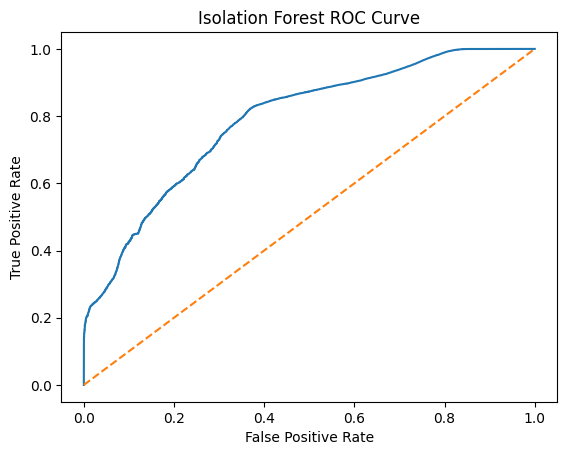

In [16]:
fpr, tpr, _ = roc_curve(y_test, anomaly_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Isolation Forest ROC Curve")
plt.show()

### Report

The Isolation Forest model achieved a ROC-AUC of approximately 0.79 on the UNSW-NB15 dataset, indicating good ranking performance in distinguishing malicious traffic from normal network flows. The model demonstrated high precision (≈97%) with a very low false-positive rate, but conservative thresholding resulted in lower recall, meaning a portion of attack traffic was not flagged. This behavior reflects realistic intrusion detection systems, which often prioritize alert quality over volume. To improve detection performance, especially recall and overall discriminative power, a neural network–based autoencoder can be trained on normal traffic to capture non-linear patterns of benign behavior, typically yielding higher ROC-AUC and improved anomaly sensitivity on complex datasets like UNSW-NB15.